# TRANSFORMER

Notebook dedicated to the study of various aspects of the transformer. We code
a decoder-only transformer and train it on two different tasks: reversing
sequences of numbers and generating text. We follow the suggested exercise of the GitHub repository
[deep_learning_curriculum](https://github.com/ckkissane/deep_learning_curriculum/blob/master/1-Transformers.md). We choose to write most functions explicitely in this notebook for pedagogical purposes. Only some layers of the transformer are hidden in the file torch_layers.py.

In [1]:
# Uncomment for collab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import re
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Algorithms/GIT/Transformer')
import torch_layers
torch.__version__

'2.0.1+cu118'

In [3]:
# Check device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Positional Encoding

Text(0.5, 1.0, 'positional encoding, N = 100, d_model = 700')

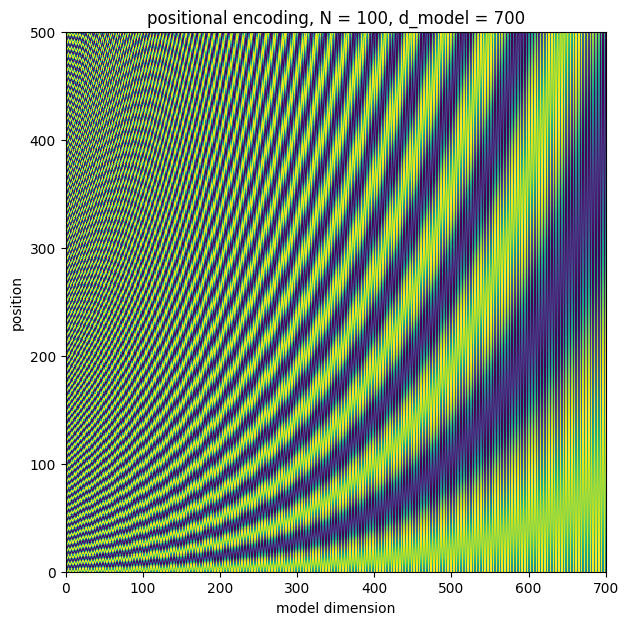

In [4]:
N = 100
d_model = 700
t = torch.arange(0, 500)
fig = plt.figure(figsize=(6, 6), dpi=100)
axes = fig.add_axes([0.1, 0.1, 0.9, 0.9])
axes.pcolormesh(torch_layers.pos_encoding(N, d_model)(t), cmap='viridis')
axes.set_ylabel('position')
axes.set_xlabel('model dimension')
axes.set_title('positional encoding, N = 100, d_model = 700')

## Decoding-only Transformer

We define an decoding only transformer:

- N controls the frequency of the positional encoding
- num_heads controls the number of heads in each attention layer
- d_model is the position-wise hidden dimension (d_model = num_heads * headsize)
- vocab_size is the dimension of the output position wise vector
- n_blocks is the number of attention layers
- dropout controls the dropout proba of each attention layer (0 < dropout < 1)

In [5]:
class Transformer(torch.nn.Module):
    def __init__(self, N, num_heads, d_model, n_blocks, vocab_size, dropout):
        super().__init__()
        self.N = N
        self.num_heads = num_heads
        self.d_model = d_model
        self.n_blocks = n_blocks
        self.embed = torch.nn.Embedding(vocab_size, d_model)
        self.pos_enc = torch_layers.pos_encoding(N, d_model)
        self.DecoderBlocks = torch.nn.Sequential(
            *[torch_layers.DecoderBlock(num_heads, d_model, dropout) for k in range(n_blocks)]
        )
        self.LN = torch_layers.LayerNorm(-1, d_model)
        self.linear_output = torch.nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, x):
        """
        x: torch.tensor(batch_size, seq_length)
        elements of x are integers in range(vocab_size)
        out: torch.tensor(batch_size, seq_length, vocab_size)
        ouput = proba over vocabulary
        """

        seq_length = x.size()[-1]
        # Embedding
        x = self.embed(x) # output: torch.tensor(batch_size, seq_length, d_model)
        # Positional encoding
        p = self.pos_enc(torch.arange(0, seq_length))
        x = x + p.to(self.embed.weight.device)
        # Application n_blocks * (attention + feed forward)
        x = self.DecoderBlocks(x)
        # Layer norm
        x = self.LN(x)
        # Linear layer d_model -> vocab_size
        x = self.linear_output(x)
        return x

## Samplers

We define three types of samplers, the first one samples an input and the corresponding target (X, y) in the training set, the second one samples an output an the corresonding target (output, y) in the training set and the third one samples an output and the corresponding target in the test set.

In [6]:
def data_sampler(datas, model):
    n_batch = random.randint(0, datas.n_batches - 1)
    batch_element = random.randint(0, datas.batch_size - 1)
    X, y = datas[n_batch]
    return X[batch_element], y[batch_element]

def output_sampler(datas, model):
    X_sampled, y_sampled = data_sampler(datas, model)
    output_sampled = model(X_sampled).argmax(dim=-1)
    return output_sampled, y_sampled

def test_output_sampler(datas, model):
    test_element = random.randint(0, datas.test_size - 1)
    X_test, y_test = datas.test()
    return model(X_test[test_element]).argmax(dim=-1), y_test[test_element]


# Reversing sequences

### Definition of the dataset

- Input = sequence of numbers.
- Output = same sequence but reversed.
- Each element of the sequence is a number between 0 and (max_digit - 1).

In [7]:
class dataload():

  def __init__(self, batch_size, n_batches, seq_length, max_digit, test_size):
      self.batch_size = batch_size
      self.n_batches = n_batches
      self.seq_length = seq_length
      self.max_digit = max_digit
      self.data_size = self.batch_size * self.n_batches
      # X = torch.tensor(n_batch, batch_size, seq_length)
      self.X = torch.randint(0, self.max_digit, (self.n_batches, self.batch_size, self.seq_length))
      # Y = torch.tensor(n_batch, batch_size, seq_length)
      self.Y = torch.flip(self.X, dims=(-1,))
      # Defines a random test set
      # X = torch.tensor(test_size, seq_length)
      self.test_size = test_size
      self.X_test = torch.randint(0, self.max_digit, (test_size, self.seq_length))
      # Y = torch.tensor(test_size, seq_length)
      self.y_test = torch.flip(self.X_test, dims=(-1,))
  def __getitem__(self, index):
     return (self.X[index], self.Y[index])

  def test(self):
      return self.X_test, self.y_test

### Instantiation of the data and the model

In [15]:
# data set
batch_size = 100
n_batches = 1000
seq_length = 6
max_digit = 10
data_size = batch_size * n_batches
test_size = 1000
datas = dataload(batch_size, n_batches, seq_length, max_digit, test_size)

# model hyper parameters
N = 1000
num_heads = 4
d_model = 20
n_blocks = 4
vocab_size = datas.max_digit
dropout = 0.1

# instantiation of the model
Tr = Transformer(N, num_heads, d_model, n_blocks, vocab_size, dropout)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Tr.parameters(), lr=6e-4)
Tr.to(device).train();

# Sample an input vs target
X_sampled, y_sampled = data_sampler(datas, Tr)
print(f'input  = {X_sampled},\noutput = {y_sampled}')

input  = tensor([1, 7, 2, 1, 1, 5]),
output = tensor([5, 1, 1, 2, 7, 1])


Notice how the sequence is reversed.

### Training

There are $batch\_size * n\_batches$ randomly sampled sequences in the dataset (with uniform distribution) and there are $max\_digit^{seq\_length}$ possible sequences. In our case the former is $10^5$ while the latter is $10^6$. Since the number of possible sequences is an order of magnitude larger than the number of sequences sampled for the dataset, the number of original sequences in the dataset is approximatively equal to the number of sequences in the dataset. The exact number of original sequences can be obtained using the 'coupon collector's problem' and the exact result is obtained by finding the integer $p$ which solves the equation $\sum_{i=1}^p \frac{N}{N - (i + 1)} = data\_size$, where $N$ is the number of possible sequences (the solution is 95163 in our case).


Execution time: 20.00376582145691 seconds


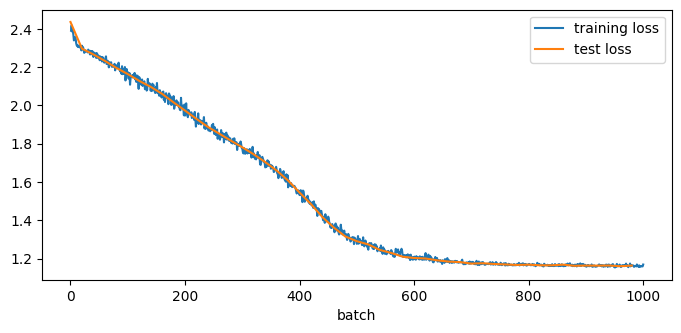

In [16]:
start_time = time.time()

losses = []
losses_test = []
max_gradient_norm = 1.0 # For gradient clipping
X_test, y_test = datas.test()
batch = 0
for data in datas:
    X = data[0].to(device)
    y = data[1].to(device)
    # Forward
    optimizer.zero_grad()
    output = Tr(X) # output = torch.tensor(batch_size, seq_length, vocab_size)
    # We reshape output to (batch_size * seq_length, vocab_size) and target to (batch_size * seq_length)
    # The -1 means that pytorch finds the right dimension to ensure compatibility
    loss = criterion(output.reshape(-1, output.size()[-1]), y.reshape(-1))
    # Test
    if batch % 20 == 0:
        output_test = Tr(X_test.to(device))
        test_loss = criterion(output_test.reshape(-1, output_test.size()[-1]), y_test.to(device).reshape(-1))
        losses_test.append((batch, test_loss.item()))
    # Backward
    loss.backward()
    # Perform gradient clipping
    torch.nn.utils.clip_grad_norm_(Tr.parameters(), max_gradient_norm)
    # Update
    optimizer.step()
    batch += 1
    losses.append((batch, loss.item()))

fig = plt.figure(figsize=(7, 3))
axes = fig.add_axes([0.1, 0.1, 0.9, 0.9])
axes.plot(*list(zip(*losses)), label='training loss')
axes.plot(*list(zip(*losses_test)), label='test loss')
axes.set_xlabel('batch')
axes.legend(loc=0)
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

<div style="text-align: justify">
Notice that the loss doesn't go to zero, this is because the algorithm is using
a masked attention and therefore cannot give the right resut for the first half
of the sequence. This means that if we now test the algorithm, half of the
predicted digits should be wrong.
</div>

<div style="text-align: justify">
This is a good way to see that the only layer of the algorithm that allows
information to flow between positions is the attention layer, hence the title
'Attention is all you need'.
</div>

### Test

In [17]:
Tr.eval().to('cpu');

We sample random inputs/outputs

In [18]:
output_test_sample, y_test_sample = test_output_sampler(datas, Tr)
print(f'target sequence:   {y_test_sample.tolist()}')
print(f'predicted sequence {output_test_sample.tolist()}')

target sequence:   [9, 7, 5, 6, 2, 3]
predicted sequence [9, 2, 2, 6, 2, 3]


<div style="text-align: justify">
Notice how the first part of the sequence is always wrong.
</div>

We start by computing the number of errors in the dataset for the first half of the sequence only. We can predict this number: assuming that the first half of the sequence is predicted randomly, the probability for a digit to be right is $p_{digit} = 1\,/\,max\_digit$. The expected result is therefore $Errors = test\_size * sequence\_length\,/\,2 * (1 - p_{digit})$ which is equal to 2700 in our case.

In [19]:
predicted_errors = test_size * (seq_length / 2) * (1 - 1 / max_digit)
print(f'Predicted number of errors in the fist half of the sequence = {int(predicted_errors)}')

Predicted number of errors in the fist half of the sequence = 2700


In [20]:
# we first compute the number of errors in the first half of the sequence
output_test = Tr(X_test).argmax(dim=-1)
output_test_begining = output_test[:, 0:seq_length // 2]
y_test_begining = y_test[:, 0:seq_length // 2]
errors_begining = torch.abs((output_test_begining != y_test_begining).to(int)).sum().item()
print(f'The number of errors in the fist half of the sequence is {errors_begining}')

The number of errors in the fist half of the sequence is 2700


<div style="text-align: justify">
Number of errors in the second half of the sequence.
</div>

In [21]:
# we now compute the number of errors in the second half of the sequence
output_test_end = output_test[:, seq_length // 2:]
y_test_end = y_test[:, seq_length // 2:]
errors_end = torch.abs((output_test_end != y_test_end).to(int)).sum().item()
print(f'The number of errors in the fist half of the sequence is {errors_end}')

The number of errors in the fist half of the sequence is 0


<div style="text-align: justify">
The number of errors is much lower in the second half of the sentence, which confirms our hypothesis to explain why the loss doesn't go to zero.
</div>

# Training on a large corpus of text

### Loading data

We define a dataloader class in which we tokenize a text file of all the Beatles songs. The input X is a squence of $context\_size$ tokens, while the target y is the same sequence but shifted by one token.

In [ ]:
# Local
#file_path = '/Users/owner/Library/CloudStorage/GoogleDrive-marteau.charles.75@gmail.com/My Drive/Colab Notebooks/Deep Learning/Algorithms/Transformer/Beatles.txt'

# Collab
file_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Algorithms/Transformer/Beatles.txt'


class dataloader_text():

  def __init__(self, file_path, batch_size, context_size):
    self.file_path = file_path
    self.batch_size = batch_size
    self.context_size = context_size
    self.file = open(file_path, 'r') # Open the file in read mode
    self.contents = self.file.read() # Read the entire contents of the file
    self.corpus = re.split(r"\b", self.contents)# Split the text into tokens
    self.data_size = len(self.corpus)
    self.n_batches = (self.data_size - (self.context_size + 1)) // self.batch_size
    self.vocab = sorted(list(set(self.corpus))) # Create a vocabulary list
    self.vocab_size = len(self.vocab)
    self.stoi = {word : index for index, word in enumerate(self.vocab)} # string to index
    self.itos = {index : word for index, word in enumerate(self.vocab)} # indices to string
    self.batches = self.batched(self.corpus)

  def stoi_function(self, x):
    return self.stoi[x]

  def itos_function(self, x):
    return self.itos[x]

  def batched(self, corpus):
    corpus_tokenized = torch.tensor(list(map(lambda x : self.stoi_function(x), corpus))) # To numbers
    sequences = [
      corpus_tokenized[k: k + (self.context_size + 1)].reshape(1, (self.context_size + 1))
      for k in range(self.data_size - (self.context_size + 1))
      ] # list of (context_size + 1) sequences
    random.shuffle(sequences)
    # batches = list of n_batches tensors of shape = (batch_size, vocab_size)
    # whose elements belong to {0, vocab_size - 1}
    batches = [
      torch.cat(sequences[k*self.batch_size: (k+1)*self.batch_size], dim=0)
                     for k in range(len(sequences) // self.batch_size)
                     ]
    return batches

  def __getitem__(self, index):
    X = self.batches[index][:, :-1]
    y = self.batches[index][:, 1:]
    return X, y


### Instantiation of the data and the model

In [ ]:
# Data
context_size = 128
batch_size = 64

datas = dataloader_text(file_path, batch_size, context_size)
print(f'The number of batches is {datas.n_batches} and the batch size is {datas.batch_size}')
print(f'The text contains {datas.data_size} words and a vocabulary of size {datas.vocab_size}')

# Model hyperparamters
N = 10000
num_heads = 8
seq_length = context_size
d_model = 512
n_blocks = 6
vocab_size = datas.vocab_size
dropout = 0.1

# Instantiation model
Tr = Transformer(N, num_heads, d_model, n_blocks, vocab_size, dropout)

optimizer = torch.optim.Adam(Tr.parameters(), lr=6e-4)
criterion = torch.nn.CrossEntropyLoss()

Tr.to(device).train();

The number of batches is 1177 and the batch size is 64
The text contains 75515 words and a vocabulary of size 3013


### Training

Our goal is to overfit the training set, we only want to make sure the transformer works.

In [ ]:
start_time = time.time()

losses = []
n_epochs = 4
loss = torch.tensor(100)
batch = 0
for epoch in range(n_epochs):
    for X, y in datas:
        if loss.item() <= 0.5: break
        X_device = X.to(device) # torch.tensor(batch_size, context_size) with values in range(vocab_size)
        y_device = y.to(device) # torch.tensor(batch_size, context_size) with values in range(vocab_size)
        optimizer.zero_grad()
        output = Tr(X_device) # un-normalized logits torch.tensor(batch_size, context_size, vocab_size)
        # We reshape output to (batch_size*context_size, vocab_size) and target to (batch_size*context_size)
        # The -1 means that pytorch finds the right dimension to ensure the compatibility
        loss = criterion(output.reshape(-1, output.size()[-1]), y_device.reshape(-1))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch % 50 == 0:
            print(f'batch {batch + 1}, loss = {loss.item()}')
        batch += 1

end_time = time.time()
execution_time = end_time - start_time
print(f'Execution time: {execution_time} seconds')
print(f'The number of processed batches is {len(losses)}')

batch 1, loss = 8.07288932800293
batch 51, loss = 3.900002956390381
batch 101, loss = 3.355640172958374
batch 151, loss = 2.8057572841644287
batch 201, loss = 2.0750656127929688
batch 251, loss = 1.1881217956542969
batch 301, loss = 0.7000645995140076
Execution time: 682.6806099414825 seconds
The number of processed batches is 319


Only approximatively half of the dataset has been processed.

(0.0, 8.07288932800293)

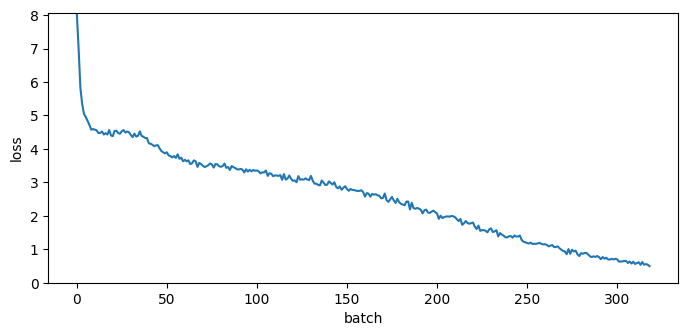

In [ ]:
# Plot of the loss
fig = plt.figure(figsize=(7, 3))
axes = fig.add_axes([0.1, 0.1, 0.9, 0.9])
axes.plot(list(range(len(losses))), losses)
axes.set_ylabel('loss')
axes.set_xlabel('batch')
axes.set_ylim(0, max(losses))

Save weights of the model

In [ ]:
# We save the weigths of our Transformer

# Specify the path to the folder where you want to save the weights
save_folder = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/Algorithms/Transformer"

# Specify the file name for the saved weights
save_filename = "Transformer_weights.pth"

# Save the model weights
torch.save(Tr.state_dict(), save_folder + "/" + save_filename)

## Evaluation and Inference

Load the model

In [ ]:
# We load the weights of our Transformer into a freshly prepared one

# Local
#loading_path = '/Users/owner/Library/CloudStorage/GoogleDrive-marteau.charles.75@gmail.com/My Drive/Colab Notebooks/Deep Learning/Algorithms/GIT/Transformer/Transformer_weights.pth'

# Collab
loading_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Algorithms/Transformer/Transformer_weights.pth'

Tr = Transformer(N, num_heads, d_model, n_blocks, vocab_size, dropout)
Tr.load_state_dict(torch.load(loading_path, map_location=device))
Tr.to('cpu').eval();

We test our training using the output sampler which returns an output vs target

In [ ]:
output_sampled, y_sampled = output_sampler(datas, Tr)
errors_sample = (output_sampled != y_sampled).sum().item() # Counts the number of errors
print(f'There are {errors_sample} errors in the sequence of length {seq_length}')

There are 16 errors in the sequence of length 128


Basic inference: sample from the output probability one word after the other

In [ ]:
Tr.to(device)

class inference():
    def __init__(self, data, model):
      self.data = data
      self.model = model

    def __call__(self, prompt, length):
      """
      Generates a text that uses the prompt as a seed. The prompt is a string
      and length is the number of tokens in the generated text.
      """
      out_sentence = prompt
      tokens = re.split(r"\b", out_sentence) # Split the text into tokens
      input = list(map(lambda x: self.data.stoi_function(x), tokens)) # Tokens to numbers
      for k in range(length):
        X = torch.tensor(input).reshape(1, len(input)).to(device) # dim = (batch_size = 1, seq_length)
        with torch.no_grad():
          output = Tr(X)
        proba_next_token = torch_layers.softmax(-1)(output)[:, -1] # We extract the last logit which defines a multinomial proba distrib over the vocabulary
        token = torch.multinomial(proba_next_token.reshape(proba_next_token.size()[-1]), 1)
        input.append(token.item()) # We add the number sampled to the input
        out_sentence = ''.join([out_sentence, self.data.itos_function(token.item())]) # We also add it to the sentence

      print(out_sentence)

Apply the inference to the prompt

In [ ]:
inference(datas, Tr)(prompt = "Baby I am", length = 150)

Baby I am like a stoney

You're gonna that only lot to change of what to do
When I'm going to home
Back my mind can stop and it's understood
pride That before

Baby, you should drive my car
And maybe I'll love you
(and that I)
I hope you do, yeah, yeah
Oh, you know two, boys? (yeah, yeah, boys)
yeah
Yeah, boys)
Hey, boys)
(boys)
Whoo! Pop and and feeling it's


The song doesn't make much sense: there isn't really a long range correlation between words. Some pieces make sense but the global meaning is rather poor.

Function that generates the next word

In [ ]:
def generate_next_words(input_seq, beam_width):

    X = torch.tensor(input_seq).to(device)
    with torch.no_grad():
        output = Tr(X)
    proba_next_token = torch_layers.softmax(-1)(output)[:, -1].reshape(data.vocab_size)
    topk_probs, topk_words = torch.topk(proba_next_token, beam_width)
    return topk_probs, topk_words

More sofisticated inference using beam search:

<div style="text-align: justify">
We feed the prompt to the model and identify the k words that have the highest probability. This produces k candidate sentences. We then feed the k sentences to the model and for each sentence we identify the k most probable next words. We now have k**2 candidate sentences. Each sentence has a proba given by the product of the two proababilities or equivalently a log proba given by the sum. We select the kth most probable combinations and then apply the same operation to the next word, etc. Until we have formed a sentence of appropriate length. We conclude by sampling over the set of candidate sentences.
</div>

In [ ]:
class inference_beam():
    def __init__(self, data, model):
      self.data = data
      self.model = model

    def beam_search(self, input_seq, beam_width, length):

      candidates = [(0, input_seq)] # list of (log proba, seq_candidate)
      for n in range(length):
        X = torch.tensor([candidates[k][1] for k in range(len(candidates))]).to(device)
        output = Tr(X)
        proba_next_word = torch_layers.softmax(-1)(output)[:, -1, :] # dim = (len(candidates), vocab_size)
        topk_probs, topk_words = torch.topk(proba_next_word, beam_width, dim=-1) # dim = (len(candidates), beam_width)
        # Create a len(candidates)*k matrix whose elements are the (log_proba_candidate + log_proba_next_word)
        Matrix = torch.zeros(len(candidates), beam_width)
        for k in range(len(candidates)):
          for l in range(beam_width):
            Matrix[k, l] = candidates[k][0] + torch.log(topk_probs[k, l]).item()
        vals, indices = torch.topk(torch.flatten(Matrix), beam_width)
        indices = np.unravel_index(indices.numpy(), Matrix.size())
        indices = list(zip(list(indices[0]), list(indices[1])))
        candidates_new = []
        for x, y in indices:
          candidates_new.append((Matrix[x, y].item(), candidates[x][1] + [topk_words[x, y].item()]))
        candidates = candidates_new
      log_probas, seq_candidates = list(zip(*[list(candidates[k]) for k in range(len(candidates))]))
      return torch.tensor(list(log_probas)), torch.tensor(list(seq_candidates))

    def __call__(self, prompt, beam_width, length):
      """
      Generates a text that uses the prompt as a seed. The prompt is a string
      and length is the number of tokens in the generated text.
      """

      tokens = re.split(r"\b", prompt) # Split the text into tokens
      input_seq = list(map(lambda x: self.data.stoi_function(x), tokens)) # Tokens to numbers
      log_probas, seq_candidates = self.beam_search(input_seq, beam_width, length)
      index_sampled = torch.multinomial(torch_layers.softmax(-1)(log_probas), 1)
      chosen_seq = seq_candidates[index_sampled.item()]
      new_seq = []
      for key in chosen_seq:
        new_seq.append(self.data.itos_function(key.item()))
      out_sentence = ''.join(new_seq) # We also add it to the sentence

      print(out_sentence)

In [ ]:
inference_beam(datas, Tr)(prompt = 'Baby I am', beam_width = 1, length = 100)

Baby I am a man
And I will always be my mind
I'll be there

I wanna be your man
I wanna be your man
I wanna be your man
I wanna be your man

Tell me that you love me, baby
I wanna be your man

I wanna be your man


When beam_width = 1 the result doesn't make much sense.

We try now with beam_width = 10:

In [ ]:
inference_beam(datas, Tr)(prompt = 'Baby I am', beam_width = 10, length = 100)

Baby I am and I'm feeling blue
Tell me, oh what can I do?

She thinks of him
And so she dresses in black
And though he'll never come back
She's dressed in black

Oh dear, what can I do?
Baby's in black and I'm feeling blue
Tell


In this case, the text makes much more sense, but we also seem to enter a regime in which the inference simply reproduces entire pieces of the songs and patches them (see the song Baby’s in Black).

<div style="text-align: justify">
Notice that this inference is much more rigid, in the sense that it produces most of the time the same answer. This is because it samples a single time from a probability distribution over the kth best sequences, as opposed to the previous one which samples a word as many times as there are generated words.
</div>

<div style="text-align: justify">
Another method is called 'nucleus sampling'.
This time one does not fix the number of words selected
at each step but instead one fixes the probability mass covered at each
step, i.e. the sum of all the probabilities of each word selected.
This method helps when the distribution is flat and that, therefore,
selecting the kth most probable words is not so meaningful since
there exists certaintly other words whose probabilities are comparable but
slightly smaller.
</div>